In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.arima import AutoARIMA
import warnings
warnings.filterwarnings("ignore")



In [2]:
plt.rcParams["figure.figsize"] = [12, 5]  

In [3]:
df = pd.read_csv("series.csv")

In [4]:
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


In [5]:
df.describe()

,UNITS_SOLD
count,2686.000000
mean,531.340283
std,840.944458
min,0.000000
25%,25.000000
50%,62.000000
75%,695.000000
max,7551.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


In [7]:
df.DATE = pd.to_datetime(df.DATE)

In [8]:
df_cantidades = df.groupby("CATEGORY").agg({"UNITS_SOLD":"sum"})

x = df_cantidades.index
y = df_cantidades.UNITS_SOLD

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['Unidades Vendidas de la categoria 1', 'Unidades Vendidas de la categoria 2', 'Unidades Vendidas de la categoria 3'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Unidades Vendidas por Categoria',
yaxis=dict(
        title='Unidades Vendidas',
        titlefont_size=16,
        tickfont_size=14,
    ),
xaxis=dict(
        title='Categoria',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()


### La categoria más vendida es la 3 con 1.34072M seguida de la 1 con 42.127k y la 2 con 39.333k

## Análisis CATEG-1

In [9]:
df_categ1 = df[df.CATEGORY == "CATEG-1"]
df_categ1.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
3,CATEG-1,2021-04-27,60
8,CATEG-1,2020-03-28,26
12,CATEG-1,2021-05-13,32


#### ¿Están todos los días?
#### ¿Hay días repetidos?
#### ¿Donde empieza y termina la serie de tiempo?

In [10]:
df_categ1.sort_values("DATE")

,CATEGORY,DATE,UNITS_SOLD
1526,CATEG-1,2018-10-16,1
506,CATEG-1,2019-06-11,27
1539,CATEG-1,2019-06-12,26
423,CATEG-1,2019-06-13,24
2222,CATEG-1,2019-06-14,18
...,...,...,...
1723,CATEG-1,2021-11-08,63
717,CATEG-1,2021-11-09,65
2605,CATEG-1,2021-11-10,189
736,CATEG-1,2021-11-11,194


Se puede ver que la primera fila está muy alejada de los días de las siguientes filas por lo que el dato no debe ser tenido en cuenta

In [11]:
df_categ1.drop(1526,inplace=True)

In [12]:
(df_categ1.index.value_counts() > 1).sum()

0

In [13]:
df_categ1.set_index("DATE",inplace=True)
df_categ1.asfreq("D").isna().sum()

CATEGORY      0
UNITS_SOLD    0
dtype: int64

In [14]:
df_categ1 = df_categ1.sort_index()

In [15]:
df_categ1

,CATEGORY,UNITS_SOLD
DATE,,
2019-06-11,CATEG-1,27
2019-06-12,CATEG-1,26
2019-06-13,CATEG-1,24
2019-06-14,CATEG-1,18
2019-06-15,CATEG-1,15
...,...,...
2021-11-08,CATEG-1,63
2021-11-09,CATEG-1,65
2021-11-10,CATEG-1,189


In [16]:
df_categ1.describe()

,UNITS_SOLD
count,886.000000
mean,53.189616
std,31.891344
min,8.000000
25%,31.000000
50%,47.000000
75%,65.000000
max,210.000000


#### Eliminando ese dato no hay más datos faltantes o anomalos en la serie de tiempo y hay solo 1 dato por día

In [17]:
fig = px.line(x=df_categ1.index, y=df_categ1.UNITS_SOLD, title='Unidades Vendidas a Tráves del Tiempo')
fig.update_layout(
                   xaxis_title='Fecha',
                   yaxis_title='Unidades Vendidas')
fig.show()

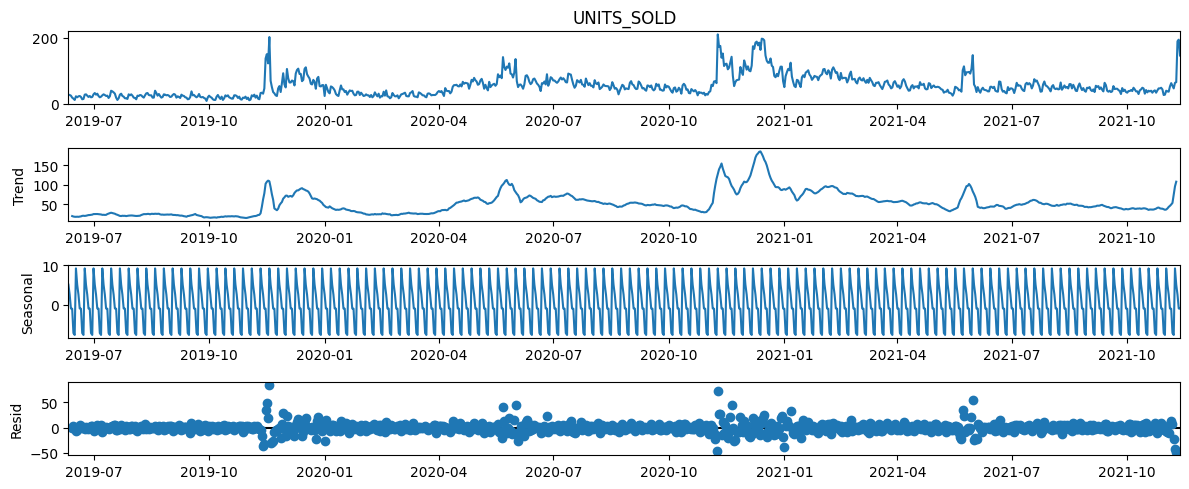

In [18]:
categ1_decomposed = seasonal_decompose(df_categ1.UNITS_SOLD,model='additive')
plot = categ1_decomposed.plot()


In [19]:
df_categ1["ANIO"] = df_categ1.index.to_series().apply(lambda x: x.year)

In [20]:
fig = go.Figure()
for anio in df_categ1.ANIO.unique():
    df_temp = df_categ1[df_categ1.ANIO == anio]
    fig.add_trace(go.Scatter(x=df_temp.index.to_series().apply(lambda x: x.replace(year=2020)), y=df_temp.UNITS_SOLD,
                        mode='lines',
                        name=str(anio)))
    

In [21]:
fig.layout.xaxis.tickvals = pd.date_range('2020-01', '2020-12', freq='MS')
fig.layout.xaxis.tickformat = '%b-%d'
fig.update_layout(title='Unidades Vendidas para cada año',
                   xaxis_title='Fecha',
                   yaxis_title='Unidades Vendidas')
fig.show()

### Conclusiones

<ul>
<li>Pareciera que hay estacionalidad entre noviembre y diciembre y junio y julio</li>
<li>No hay un trend ni hacia arriba ni hacia abajo.</li>
<li> Al tener estacionalidad es probable que la serie no sea estacionaria</li>
</ul>


## Es la serie estacionaria?
Dickey-Fuller Test

In [22]:
df_categ1 = df_categ1.UNITS_SOLD

In [23]:
from statsmodels.tsa.stattools import adfuller, kpss

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    #smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

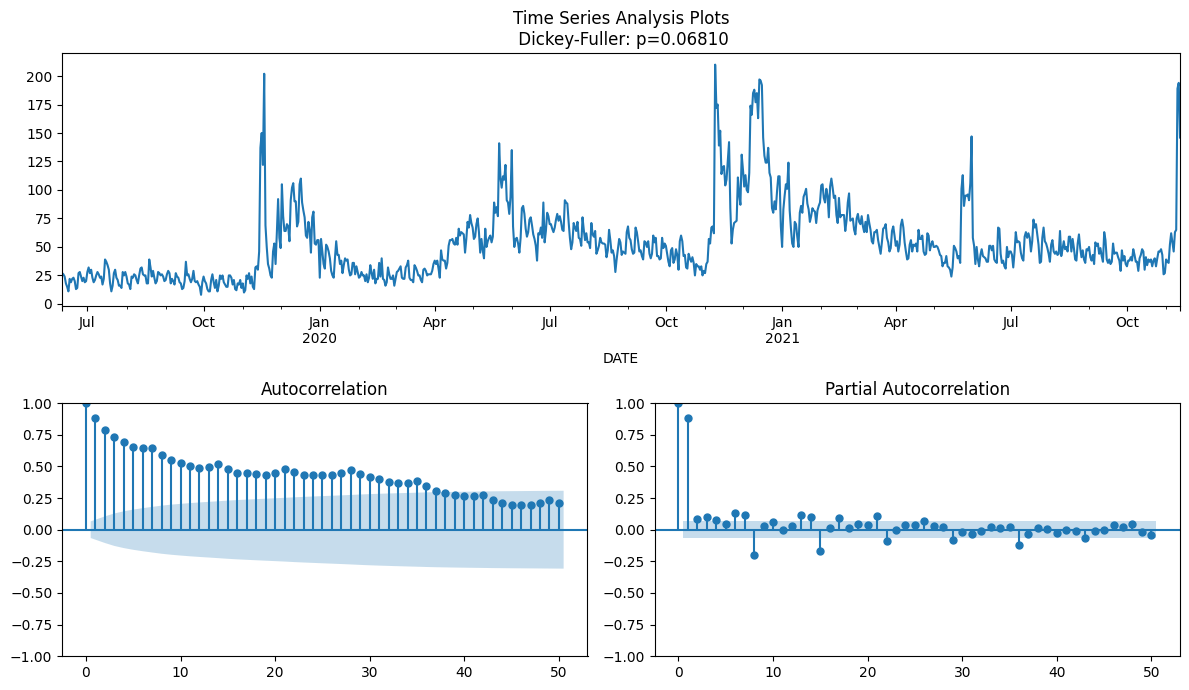

In [25]:
tsplot(df_categ1,lags = 50)

Teniendo en cuenta que en el Dickey-Fuller Test:
$$H0: La \ serie \ contiene \ "unit \ roots" \ por  \ lo \ que \ no \ es \ estacionaria \\
H_1: \neg H_0$$

Con una significancia del 5% no se rechaza la hipotesis nula, la serie no es estacionaria

Para volverla estacionaria se aplica una diferenciación de 1

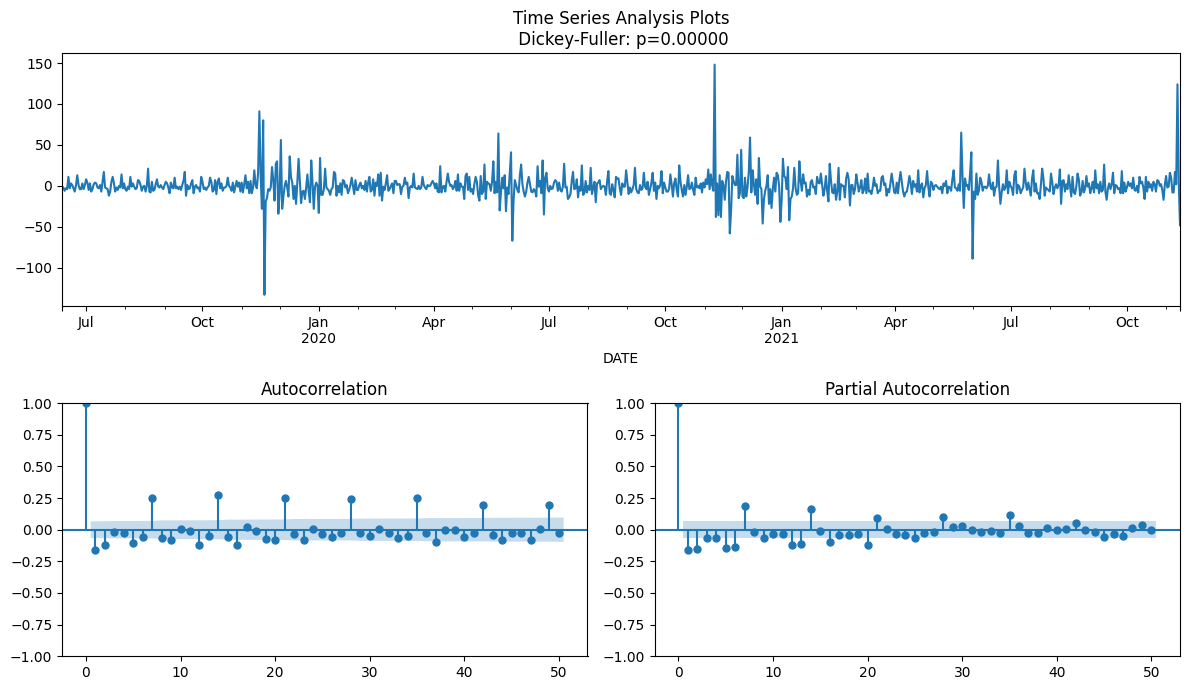

In [26]:
df_categ1_diff = df_categ1.diff().dropna()
tsplot(df_categ1_diff,lags=50)

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [45]:

test_len = 21
al_train, al_test = df_categ1.iloc[:-test_len], df_categ1.iloc[-test_len:]
al_train.index.freq = "D"
al_test.index.freq = "D"
al_train = al_train.ffill()
al_test = al_test.ffill()
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(al_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  865
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3427.073
Date:                           Fri, 09 Sep 2022   AIC                           6866.145
Time:                                   11:31:49   BIC                           6894.715
Sample:                                        0   HQIC                          6877.080
                                           - 865                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -9.94e-06      0.002     -0.006      0.995      -0.003       0.003
ar.L1          0.8066      0.020     41.082      0.000       0.768       0.845
ma.L1         -0.9579      0.014    -68.891      0.000      -0.985      -0.931
ar.S.L7        0.9874      0.007    134.068      0.000       0.973       1.002
ma.S.L7       -0.9261      0.020    -46.635      0.000      -0.965      -0.887
sigma2       160.8337      2.751     58.465      0.000     155.442     166.225
===================================================================================
Ljung-Box (L1) (Q):                   7.88   Jarque-Bera (JB):             35403.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

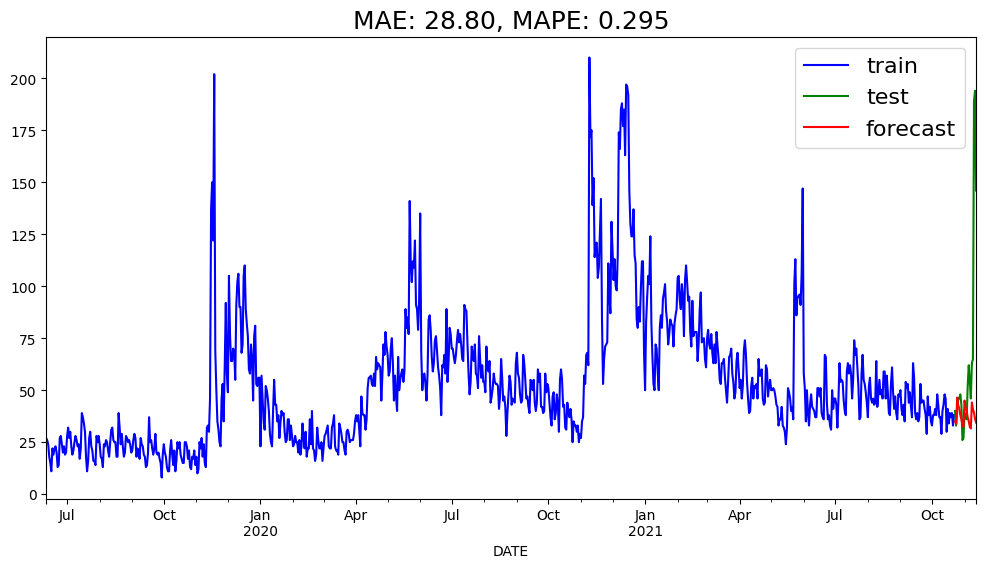

In [46]:
fh = np.arange(test_len) + 1
forecast = forecaster.predict(fh=fh)
al_arima_mae, al_arima_mape = plot_forecast(al_train, al_test, forecast)

In [47]:
steps = 21
data_train = df_categ1[:-steps]
data_test  = df_categ1[-steps:]

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=25),
                lags = 30
                )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=25) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 864] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 25, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-09 11:33:33 
Last fit date: 2022-09-09 11:33:34 
Skforecast version: 0.4.3 

In [50]:
steps = 21
predictions = forecaster.predict(steps=steps)
predictions.head(5)

865    35.34
866    34.76
867    37.28
868    35.40
869    36.62
Name: pred, dtype: float64

In [51]:
predictions.index = data_test.index

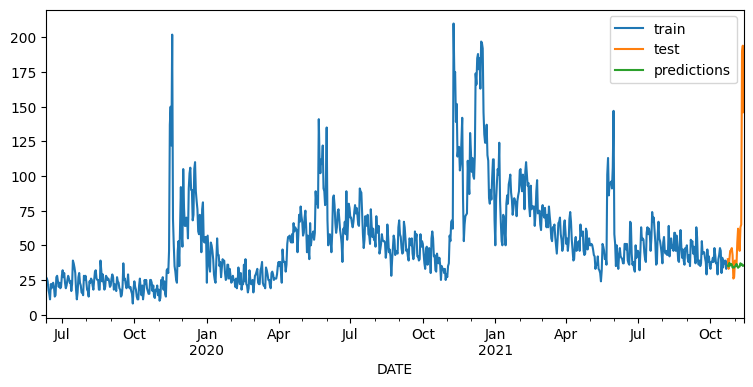

In [52]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [53]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = predictions
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.3096639050875605
Test error (MAE): 29.755714285714287


In [54]:
steps = 21
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20,30]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [10:22<00:00, 207.41s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 0.21050965366672073



In [55]:
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train)

In [56]:
predictions = forecaster.predict(steps=steps)

In [57]:
predictions.index = data_test.index

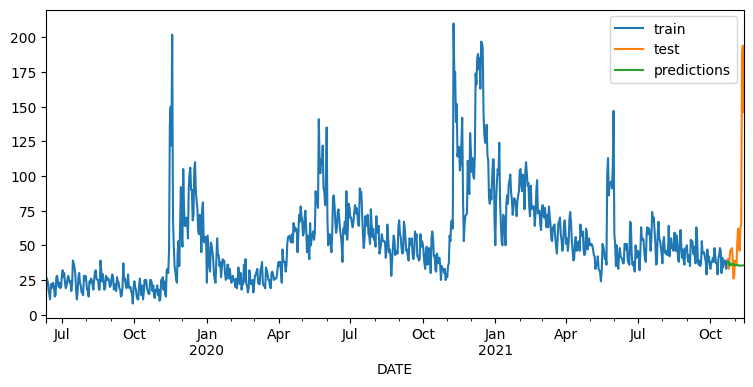

In [58]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [59]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = predictions
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.30718339364294833
Test error (MAE): 29.55033076758306


In [60]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 21,
                    lags      = 30 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20,30]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.reset_index(drop=True),
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 21,
                        refit       = True,
                        metric      = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.8),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                )

Number of models compared: 40


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:42<00:00, 10.67s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'lasso__alpha': 0.2782559402207126}
  Backtesting metric: 0.21430046908351796



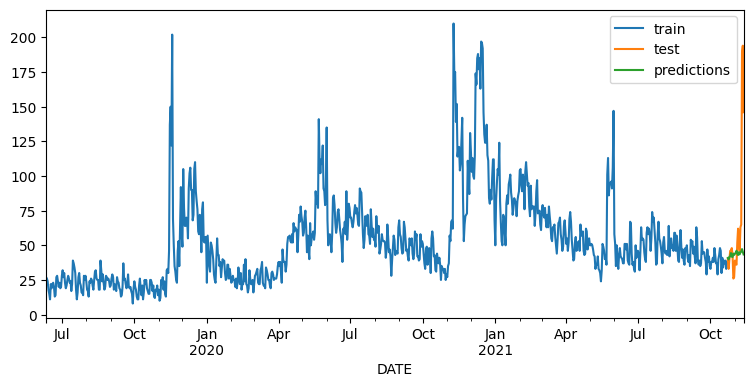

In [61]:
predictions = forecaster.predict()
predictions.index = data_test.index
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [62]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = predictions
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.28249706427272975
Test error (MAE): 26.09517432786252


In [63]:
from prophet import Prophet
df_prophet = df_categ1.reset_index()
df_prophet.columns = ['ds', 'y']
model = Prophet()
# fit the model
model.fit(df_prophet)

prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/g1/r1qwy2vx49v696rj631wf8140000gp/T/tmpsjrk8xss/4rytg2c1.json
cmdstanpy  DEBUG input tempfile: /var/folders/g1/r1qwy2vx49v696rj631wf8140000gp/T/tmpsjrk8xss/5stkqp2k.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/vduarteb/opt/anaconda3/envs/MELI/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54883', 'data', 'file=/var/folders/g1/r1qwy2vx49v696rj631wf8140000gp/T/tmpsjrk8xss/4rytg2c1.json', 'init=/var/folders/g1/r1qwy2vx49v696rj631wf8140000gp/T/tmpsjrk8xss/5stkqp2k.json', 'output', 'file=/private/var/folders/g1/r1qwy2vx49v696rj631wf8140000gp/T/tmp1ipn9exz/prophet_model-20220909114518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:45:18 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start proce

In [64]:
forecast = model.predict(df_prophet[-21:])

In [65]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


           ds       yhat  yhat_lower  yhat_upper
0  2021-10-23  21.670858   -1.245560   45.685553
1  2021-10-24  22.565626   -1.865093   44.270525
2  2021-10-25  41.185755   17.142089   62.508987
3  2021-10-26  38.920783   15.558570   63.197106
4  2021-10-27  39.109731   15.636808   62.498108
5  2021-10-28  37.962431   15.415004   62.214907
6  2021-10-29  40.052035   17.443858   63.473796
7  2021-10-30  36.080948   13.026325   59.482219
8  2021-10-31  38.663235   17.091118   61.145147
9  2021-11-01  58.806330   36.292509   80.666218
10 2021-11-02  57.871526   36.733798   81.641788
11 2021-11-03  59.173731   34.894199   81.964693
12 2021-11-04  58.903427   35.173111   82.873743
13 2021-11-05  61.619682   38.836776   84.711614
14 2021-11-06  58.016463   34.087985   81.347266
15 2021-11-07  60.705286   39.177984   85.656779
16 2021-11-08  80.697000   56.486989  104.691038
17 2021-11-09  79.362223   56.463047  101.887747
18 2021-11-10  80.030867   55.484173  101.962549
19 2021-11-11  78.91

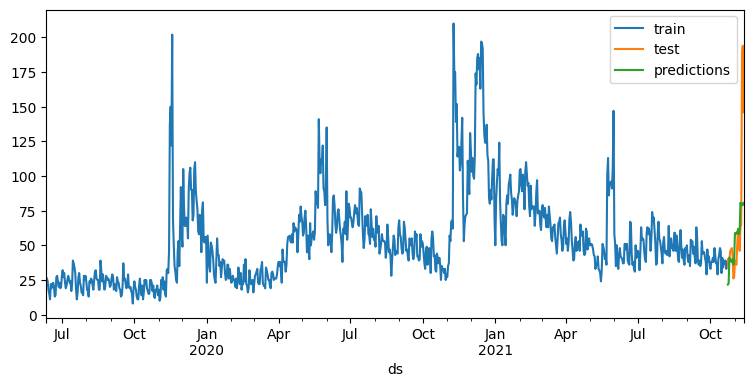

In [66]:
forecast.set_index("ds",inplace=True)
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
forecast['yhat'].plot(ax=ax, label='predictions')
ax.legend();

In [67]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = forecast['yhat']
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = forecast['yhat']
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.31301743672004306
Test error (MAE): 23.334534377657228


In [85]:
df_categ2 = df[df.CATEGORY == "CATEG-2"]
df_categ2.head()

,CATEGORY,DATE,UNITS_SOLD
2,CATEG-2,2021-10-26,23
4,CATEG-2,2021-05-05,61
7,CATEG-2,2020-08-23,28
10,CATEG-2,2020-01-25,3
11,CATEG-2,2019-10-14,3


In [86]:
df_categ2.sort_values("DATE")

,CATEGORY,DATE,UNITS_SOLD
59,CATEG-2,2018-10-16,1
2369,CATEG-2,2019-06-11,15
1503,CATEG-2,2019-06-12,13
92,CATEG-2,2019-06-13,8
814,CATEG-2,2019-06-14,9
...,...,...,...
936,CATEG-2,2021-11-08,21
1299,CATEG-2,2021-11-09,13
2288,CATEG-2,2021-11-10,18
2538,CATEG-2,2021-11-11,20


In [87]:
df_categ2.drop(59,inplace=True)

In [88]:
(df_categ1.index.value_counts() > 1).sum()

0

In [89]:
df_categ2.set_index("DATE",inplace=True)
df_categ2.asfreq("D").isna().sum()

CATEGORY      8
UNITS_SOLD    8
dtype: int64

In [90]:
df_categ2 = df_categ2.asfreq('D').ffill()

In [91]:
df_categ2 = df_categ2.sort_index()

In [92]:
df_categ2

,CATEGORY,UNITS_SOLD
DATE,,
2019-06-11,CATEG-2,15.0
2019-06-12,CATEG-2,13.0
2019-06-13,CATEG-2,8.0
2019-06-14,CATEG-2,9.0
2019-06-15,CATEG-2,9.0
...,...,...
2021-11-08,CATEG-2,21.0
2021-11-09,CATEG-2,13.0
2021-11-10,CATEG-2,18.0


In [93]:
df_categ2.asfreq("D").isna().sum()

CATEGORY      0
UNITS_SOLD    0
dtype: int64

In [94]:
df_categ2.describe()

,UNITS_SOLD
count,886.000000
mean,44.474041
std,59.310853
min,1.000000
25%,9.000000
50%,19.000000
75%,51.000000
max,332.000000


#### Eliminando ese dato no hay más datos faltantes o anomalos en la serie de tiempo y hay solo 1 dato por día

In [95]:
fig = px.line(x=df_categ2.index, y=df_categ2.UNITS_SOLD, title='Unidades Vendidas a Tráves del Tiempo')
fig.update_layout(
                   xaxis_title='Fecha',
                   yaxis_title='Unidades Vendidas')
fig.show()

In [96]:
df_categ2["ANIO"] = df_categ2.index.to_series().apply(lambda x: x.year)

In [97]:
fig = go.Figure()
for anio in df_categ2.ANIO.unique():
    df_temp = df_categ2[df_categ2.ANIO == anio]
    fig.add_trace(go.Scatter(x=df_temp.index.to_series().apply(lambda x: x.replace(year=2020)), y=df_temp.UNITS_SOLD,
                        mode='lines',
                        name=str(anio)))
    

In [98]:
fig.layout.xaxis.tickvals = pd.date_range('2020-01', '2020-12', freq='MS')
fig.layout.xaxis.tickformat = '%b-%d'
fig.update_layout(title='Unidades Vendidas para cada año',
                   xaxis_title='Fecha',
                   yaxis_title='Unidades Vendidas')
fig.show()

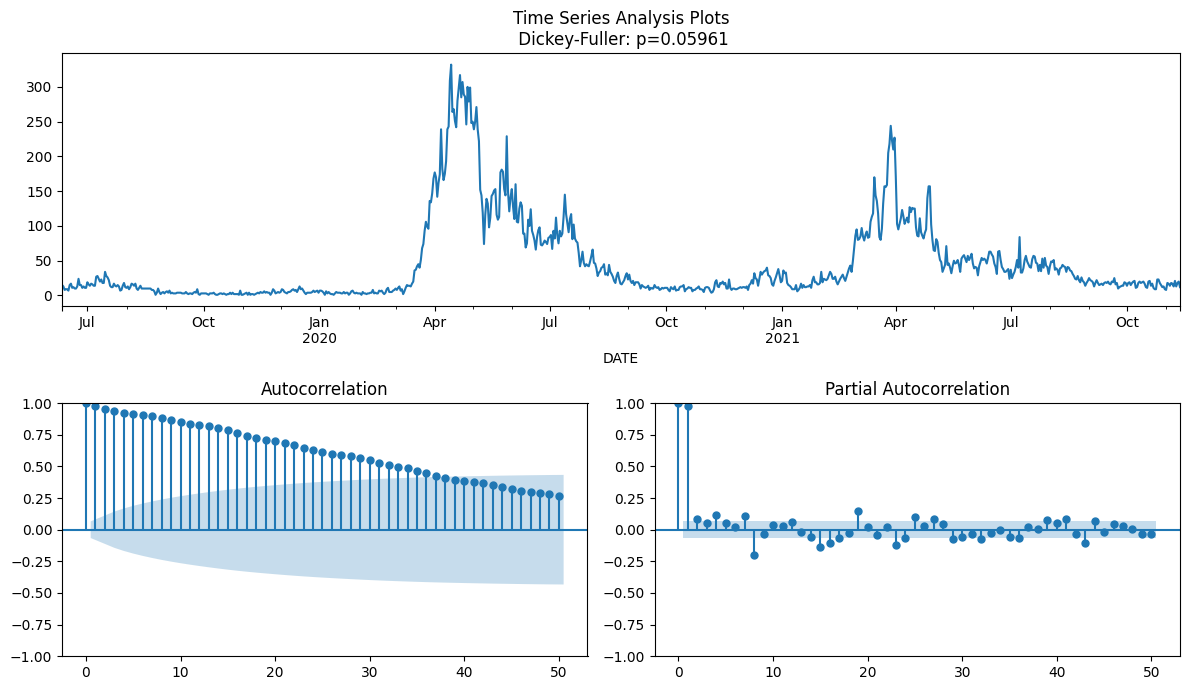

In [99]:
tsplot(df_categ2.UNITS_SOLD,lags = 50)

In [100]:
df_categ2.freq = 'D'
df_categ2 = df_categ2.UNITS_SOLD
df_categ2

DATE
2019-06-11    15.0
2019-06-12    13.0
2019-06-13     8.0
2019-06-14     9.0
2019-06-15     9.0
              ... 
2021-11-08    21.0
2021-11-09    13.0
2021-11-10    18.0
2021-11-11    20.0
2021-11-12    12.0
Freq: D, Name: UNITS_SOLD, Length: 886, dtype: float64

In [103]:
test_len = 21
al_train, al_test = df_categ2.iloc[:-test_len], df_categ2.iloc[-test_len:]
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(al_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  865
Model:             SARIMAX(3, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -3408.180
Date:                                Fri, 09 Sep 2022   AIC                           6830.360
Time:                                        11:50:10   BIC                           6863.691
Sample:                                             0   HQIC                          6843.118
                                                - 865                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1221      0.014     -8.483      0.000      -0.150      -0.094
ar.L2         -0.0605      0.019     -3.224      0.001      -0.097      -0.024
ar.L3         -0.0771      0.019     -4.145      0.000      -0.114      -0.041
ar.S.L7        0.9651      0.028     33.983      0.000       0.909       1.021
ma.S.L7       -0.8250      0.035    -23.807      0.000      -0.893      -0.757
ma.S.L14      -0.0749      0.019     -3.898      0.000      -0.113      -0.037
sigma2       155.9101      3.046     51.186      0.000     149.940     161.880
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5170.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              13.49   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

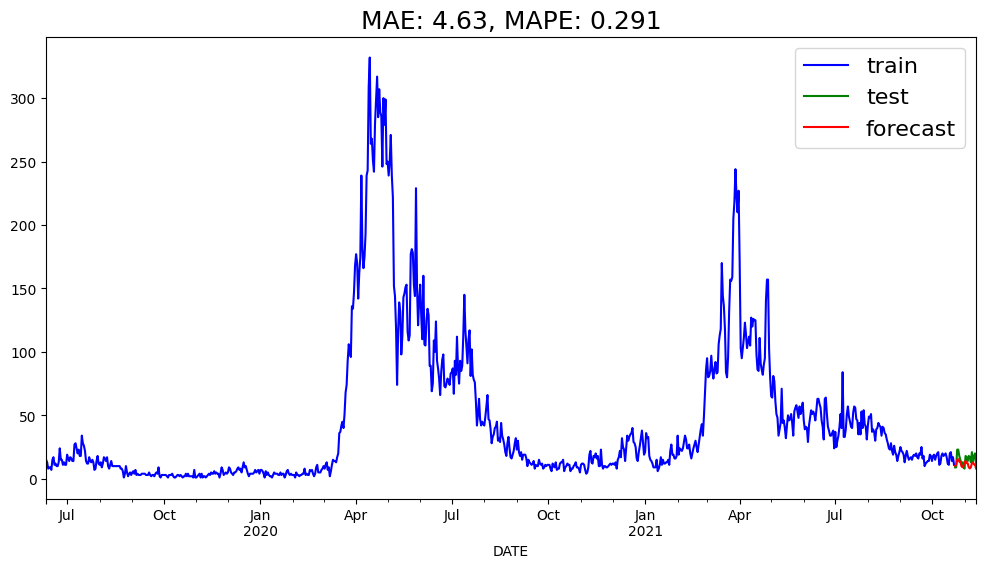

In [104]:
fh = np.arange(test_len) + 1
forecast = forecaster.predict(fh=fh)
al_arima_mae, al_arima_mape = plot_forecast(al_train, al_test, forecast)

In [105]:
steps = 21
data_train = df_categ2[:-steps]
data_test  = df_categ2[-steps:]

In [106]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=25),
                lags = 30
                )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=25) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-06-11 00:00:00'), Timestamp('2021-10-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 25, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-09 11:50:11 
Last fit date: 2022-09-09 11:50:11 
Skforecast version: 0.4.3 

In [107]:
steps = 21
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2021-10-23    11.75
2021-10-24    14.45
2021-10-25    14.83
2021-10-26    13.98
2021-10-27    14.88
Freq: D, Name: pred, dtype: float64

In [108]:
predictions.index = data_test.index

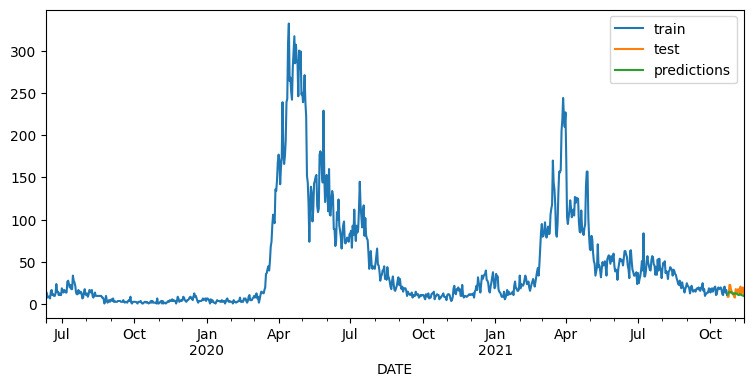

In [109]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [110]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = predictions
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.2988997911316143
Test error (MAE): 4.570952380952381


In [111]:
steps = 21
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20,30]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18


loop lags_grid:   0%|                                               | 0/3 [00:00<?, ?it/s]

In [ ]:
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train)

In [ ]:
predictions = forecaster.predict(steps=steps)

In [ ]:
predictions.index = data_test.index

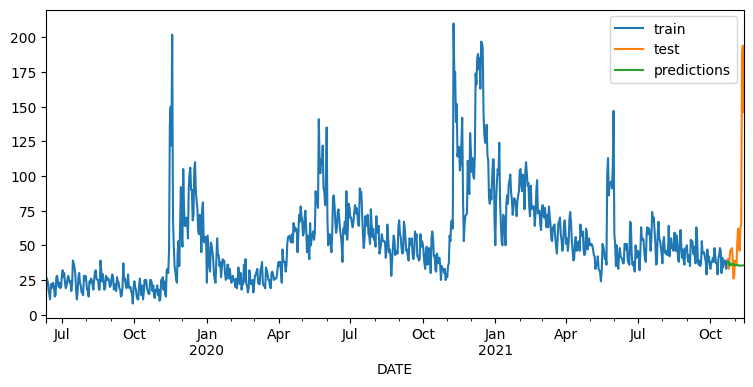

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test,
                y_pred = predictions
            )
error_mae = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (MAPE): {error_mape}")
print(f"Test error (MAE): {error_mae}")

Test error (MAPE): 0.30718339364294833
Test error (MAE): 29.55033076758306
